## **Ground-truth masks generator**
Author : *Kélian Sommer*<br>
This notebook aims to generate a keras model that classifies images.
Our objective is to create a robust model that can accurately distinguish between cloudy and clear sky images.
Default image resolution of 640x512 is too large to process. Need to bin them in 4x4, i.e. 160x128.
* Data Preprocessing: We'll explore techniques for preparing our data, including resizing, normalization, and data augmentation.
* Model Building: Using Keras, we'll construct a Convolutional Neural Network (CNN) to learn intricate patterns in the sky images.
* Model Training: We'll train our model on the prepared dataset, monitoring its performance throughout the training process.
* Model Evaluation: After training, we'll evaluate the model's accuracy and visualize its performance using various metrics and charts.

In [ ]:
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.trial import TrialState
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split

from astropy.io import fits
import numpy as np
import glob

from utilities import *
from mask_generator import *

import multiprocessing
num_cores = multiprocessing.cpu_count()
from joblib import parallel_backend, Parallel, delayed
from dask.distributed import Client
client = Client()

#### **Read FITS files : cloudy and clear (= synthetic) images**

In [2]:
def read_fits_data(filename, shape=(128, 160)):
    data = fits.getdata(filename)
    data = rebin(data, shape)
    return data

cloud_images_names = glob.glob('../CLASSIFICATION_TEST/CLOUD/*.fits')
clear_images_names = glob.glob('../CLASSIFICATION_TEST/SIM_CLEAR/*.fits')

In [3]:
with parallel_backend('threading', n_jobs=num_cores):
    cloud_images_data = Parallel(verbose=5)(delayed(read_fits_data)(filename = filename) for filename in cloud_images_names)

cloud_images_data = np.array(cloud_images_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    1.1s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    1.5s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:    1.9s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    2.4s
[Parallel(n_jobs=8)]: Done 1413 out of 1413 | elapsed:    2.9s finished


In [4]:
with parallel_backend('threading', n_jobs=num_cores):
    clear_images_data = Parallel(verbose=5)(delayed(read_fits_data)(filename = filename) for filename in clear_images_names)

clear_images_data = np.array(clear_images_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 272 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 434 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 632 tasks      | elapsed:    0.6s
[Parallel(n_jobs=8)]: Done 866 tasks      | elapsed:    0.8s
[Parallel(n_jobs=8)]: Done 1136 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 1442 tasks      | elapsed:    1.7s
[Parallel(n_jobs=8)]: Done 1784 tasks      | elapsed:    2.5s
[Parallel(n_jobs=8)]: Done 2000 out of 2000 | elapsed:    3.0s finished


In [5]:
cloud_images_data.shape, clear_images_data.shape

((1413, 128, 160), (2000, 128, 160))

#### **Data pre-processing : split into test, train, validation + normalize + create truth labels**

In [6]:
# Normalize pixel values to be between 0 and 1
norm = 2**14
cloud_images_data, test_images = cloud_images_data / norm, clear_images_data / norm

In [7]:
# 1 = cloud
# 0 = clear

cloud_labels = np.array(np.full(len(cloud_images_data), 1), dtype=np.uint8).reshape(-1, 1)
clear_labels = np.array(np.full(len(clear_images_data), 0), dtype=np.uint8).reshape(-1, 1)

In [8]:
train = np.concatenate([cloud_images_data, clear_images_data])
targets = np.concatenate([cloud_labels, clear_labels])

In [9]:
train.shape, targets.shape

((3413, 128, 160), (3413, 1))

In [10]:
X_train, X_test, y_train, y_test = train_test_split(train, targets, test_size=0.2, random_state=21)
X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.2, random_state=21)
X_train.shape, X_test.shape, X_valid.shape

((2730, 128, 160), (546, 128, 160), (137, 128, 160))

#### **Function to detect if GPU is available and does black magic**

In [11]:
# Function to get hardware strategy
def get_hardware_strategy():
    try:
        # TPU detection. No parameters necessary if TPU_NAME environment variable is
        # set: this is always the case on Kaggle.
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        tpu = None

    if tpu:
        tf.config.experimental_connect_to_cluster(tpu)
        tf.tpu.experimental.initialize_tpu_system(tpu)
        strategy = tf.distribute.experimental.TPUStrategy(tpu)
        tf.config.optimizer.set_jit(True)
    else:
        # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
        strategy = tf.distribute.get_strategy()

    return tpu, strategy

tpu, strategy = get_hardware_strategy()

#### **Define objective function for Optuna hyperparameter optimization**

In [12]:
EPOCHS = 10 # number of epochs per trial
BATCH_SIZE = 32 # batch size

def objective(trial):
    # Clear clutter from previous session graphs.
    keras.backend.clear_session()
    
    with strategy.scope():
        # Generate our trial model.

        # Define a search space for the number of layers
        num_layers = trial.suggest_int('num_layers', 1, 5)

        model = keras.Sequential()

        # Add the input layer
        model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 160, 1)))
        model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))

        # Add the hidden layers based on the suggested number of layers
        for i in range(num_layers):
            num_filters = trial.suggest_int(f'num_filters_layer{i}', 8, 64)
            model.add(keras.layers.Conv2D(num_filters, (3, 3), padding='same', activation='relu'))
            model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))

        model.add(keras.layers.Flatten())
        model.add(keras.layers.Dense(8, activation='relu'))
        model.add(keras.layers.Dense(2))

        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        #loss = tf.keras.losses.BinaryCrossentropy()
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        metrics = ['accuracy']

        model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.01, mode='auto', baseline=None, restore_best_weights=True)
        lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 10) , verbose=1)

        history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[lr_schedule, early_stopping],
                            validation_data=(X_test, y_test), verbose=1)

        # Evaluate the model accuracy on the validation set.
        #score = model.evaluate(X_valid, y_valid, verbose=1)

        # Return the validation loss as the objective to minimize
        return history.history['val_loss'][-1]
        #return score[1]

In [13]:
# Create a study object to manage the optimization process
study = optuna.create_study(direction='minimize')

# Start the optimization process
study.optimize(objective, n_trials=5)  # You can adjust the number of trials

# Print the best hyperparameters found
best_params = study.best_params
best_loss = study.best_value
print("Best hyperparameters:", best_params)
print("Best validation loss:", best_loss)

[I 2023-09-01 18:21:26,090] A new study created in memory with name: no-name-b8de2eb5-edd5-45a6-a743-63b19bd161f0



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
86/86 [==============================] - 7s 72ms/step - loss: 7.0445 - accuracy: 0.5857 - val_loss: 0.6857 - val_accuracy: 0.5861 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
86/86 [==============================] - 9s 108ms/step - loss: 0.6834 - accuracy: 0.5872 - val_loss: 0.6817 - val_accuracy: 0.5861 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
86/86 [==============================] - 9s 102ms/step - loss: 0.6804 - accuracy: 0.5872 - val_loss: 0.6797 - val_accuracy: 0.5861 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
86/86 [==============================] - 9s 106ms/step - loss: 0.6789 - accuracy: 0.5872 - val_loss: 0.6789 - val_accuracy: 0.5861 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
86/86 [==============================] - 9s 104ms/

[I 2023-09-01 18:22:54,575] Trial 0 finished with value: 0.6782540678977966 and parameters: {'num_layers': 1, 'num_filters_layer0': 45}. Best is trial 0 with value: 0.6782540678977966.



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
86/86 [==============================] - 9s 98ms/step - loss: 1.5386 - accuracy: 0.9527 - val_loss: 2.0392e-05 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
86/86 [==============================] - 8s 94ms/step - loss: 2.4198e-06 - accuracy: 1.0000 - val_loss: 8.2355e-07 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
86/86 [==============================] - 8s 98ms/step - loss: 6.6534e-07 - accuracy: 1.0000 - val_loss: 5.2007e-07 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
86/86 [==============================] - 9s 104ms/step - loss: 4.3300e-07 - accuracy: 1.0000 - val_loss: 3.5020e-07 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
86/86 [=================

[I 2023-09-01 18:24:20,507] Trial 1 finished with value: 2.2488197970460533e-08 and parameters: {'num_layers': 3, 'num_filters_layer0': 25, 'num_filters_layer1': 37, 'num_filters_layer2': 46}. Best is trial 1 with value: 2.2488197970460533e-08.



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
86/86 [==============================] - 13s 139ms/step - loss: 2.1467 - accuracy: 0.9187 - val_loss: 0.0034 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
86/86 [==============================] - 12s 134ms/step - loss: 2.6938e-04 - accuracy: 1.0000 - val_loss: 2.7292e-08 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
86/86 [==============================] - 11s 133ms/step - loss: 7.2050e-09 - accuracy: 1.0000 - val_loss: 6.5500e-10 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
86/86 [==============================] - 11s 133ms/step - loss: 1.3537e-09 - accuracy: 1.0000 - val_loss: 4.3666e-10 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
86/86 [==============

[I 2023-09-01 18:26:18,153] Trial 2 finished with value: 4.3666403826136957e-10 and parameters: {'num_layers': 3, 'num_filters_layer0': 44, 'num_filters_layer1': 63, 'num_filters_layer2': 21}. Best is trial 2 with value: 4.3666403826136957e-10.



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
86/86 [==============================] - 8s 88ms/step - loss: 1.4328 - accuracy: 0.9608 - val_loss: 0.2572 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
86/86 [==============================] - 7s 86ms/step - loss: 0.2418 - accuracy: 1.0000 - val_loss: 0.2278 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
86/86 [==============================] - 7s 84ms/step - loss: 0.2144 - accuracy: 1.0000 - val_loss: 0.2024 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
86/86 [==============================] - 7s 85ms/step - loss: 0.1907 - accuracy: 1.0000 - val_loss: 0.1802 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
86/86 [==============================] - 8s 87ms/step

[I 2023-09-01 18:27:34,847] Trial 3 finished with value: 0.09544511884450912 and parameters: {'num_layers': 3, 'num_filters_layer0': 26, 'num_filters_layer1': 19, 'num_filters_layer2': 17}. Best is trial 2 with value: 4.3666403826136957e-10.



Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
86/86 [==============================] - 11s 123ms/step - loss: 1.9384 - accuracy: 0.9487 - val_loss: 3.1359e-06 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
86/86 [==============================] - 12s 143ms/step - loss: 1.3060e-06 - accuracy: 1.0000 - val_loss: 7.2486e-07 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
86/86 [==============================] - 11s 122ms/step - loss: 2.8305e-07 - accuracy: 1.0000 - val_loss: 4.9343e-08 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
86/86 [==============================] - 10s 116ms/step - loss: 2.7684e-08 - accuracy: 1.0000 - val_loss: 4.3666e-10 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
86/86 [==========

[I 2023-09-01 18:29:29,301] Trial 4 finished with value: 0.0 and parameters: {'num_layers': 2, 'num_filters_layer0': 45, 'num_filters_layer1': 29}. Best is trial 4 with value: 0.0.


Best hyperparameters: {'num_layers': 2, 'num_filters_layer0': 45, 'num_filters_layer1': 29}
Best validation loss: 0.0


#### **Create model with best parameters from Optuna**

In [20]:
# Initialize lists to store accuracy values
accuracy_values = []

# Retrieve the best trial and best hyperparameters
best_trial = study.best_trial
best_params = best_trial.params

In [21]:
model = keras.Sequential()

# Add the input layer
model.add(keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(128, 160, 1)))
model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))

# Add the hidden layers based on the suggested number of layers
for i in range(best_params['num_layers']):
    num_filters = best_params[f'num_filters_layer{i}']
    model.add(keras.layers.Conv2D(num_filters, (3, 3), padding='same', activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), padding='same'))

model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(2))

#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
#loss = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, min_delta=0.01, mode='auto', baseline=None, restore_best_weights=True)
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 0.001 * 0.5 ** (epoch // 10) , verbose=1)

history = model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks=[lr_schedule, early_stopping],
                    validation_data=(X_test, y_test), verbose=1)


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/10
86/86 [==============================] - 9s 98ms/step - loss: 0.2821 - accuracy: 0.9722 - val_loss: 0.2785 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/10
86/86 [==============================] - 12s 143ms/step - loss: 0.2738 - accuracy: 1.0000 - val_loss: 0.2704 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/10
86/86 [==============================] - 10s 122ms/step - loss: 0.2649 - accuracy: 1.0000 - val_loss: 0.2605 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/10
86/86 [==============================] - 11s 123ms/step - loss: 0.2549 - accuracy: 1.0000 - val_loss: 0.2504 - val_accuracy: 1.0000 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/10
86/86 [==============================] - 10s 12

In [49]:
model.save('image_classificaton.keras')
#model = keras.models.load_model('path/to/location.keras')

In [29]:
history.history

{'loss': [0.2820616662502289,
  0.27382969856262207,
  0.26486754417419434,
  0.2549055814743042,
  0.24421489238739014,
  0.23234060406684875,
  0.21861211955547333,
  0.20172327756881714,
  0.1804884523153305,
  0.15423788130283356],
 'accuracy': [0.9721611738204956, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'val_loss': [0.2784644365310669,
  0.27041754126548767,
  0.2605351507663727,
  0.25035059452056885,
  0.23899589478969574,
  0.22637632489204407,
  0.2111724466085434,
  0.19226036965847015,
  0.16832271218299866,
  0.13968388736248016],
 'val_accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0],
 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001]}

#### **Metrics and other evaluation things...**

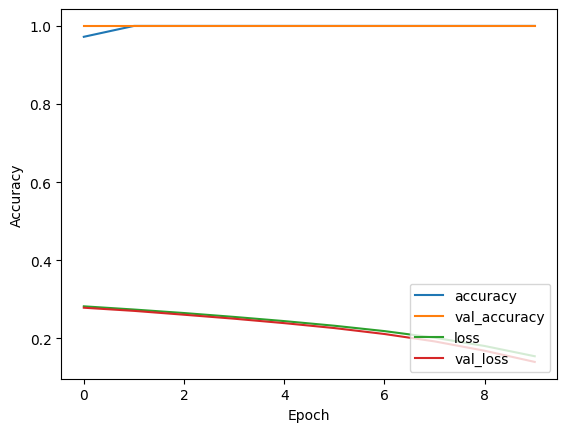

In [31]:
plt.figure()
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim([0.5, 1])
plt.legend(loc='lower right')


In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(test_acc)

18/18 - 1s - loss: 0.1397 - accuracy: 1.0000 - 569ms/epoch - 32ms/step
1.0


In [24]:
test_loss, test_acc = model.evaluate(X_valid, y_valid, verbose=2)
print(test_acc)

5/5 - 0s - loss: 0.1478 - accuracy: 1.0000 - 169ms/epoch - 34ms/step
1.0


In [36]:
predict_x=model.predict(X_test) 
classes_x=np.argmax(predict_x,axis=1)

18/18 [==============================] - 0s 24ms/step


In [37]:
classes_x

array([1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0,

In [40]:
from sklearn.metrics import precision_score
predict_x=model.predict(X_valid) 
classes_x=np.argmax(predict_x,axis=1)

5/5 [==============================] - 0s 20ms/step


In [44]:
precision_score(y_true=y_valid, y_pred=classes_x, average='binary')

1.0

In [48]:
np.array(y_valid.flatten()) == classes_x

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,